In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Opis zadania

W załączniku przesyłam dane z czujników na maszynie M1, które przesłał nam nasz kluczowy klient z **USA**.
Czy mógłbyś je przeanalizować i sprawdzić czy **średnie wibracje** nie przekraczają norm (dla tej maszyny to **3 mm/s**),
 bo jeśli tak to klient będzie ją musiał wymienić. Daj też znać **kiedy wibracje były największe**.



In [2]:
VIBRATION_LIMIT = 3.0  # [mm/s]

# Zanim zaczniemy przyjrzyjmy się danym
1. Jaki jest format pliku wejściowego
2. Czy mamy jakieś infromacje dodatkowe (nagłówek, metadane)
3. Jakie są typy danych
4. Co wiemy o jednostkach


# Wczytanie danych

1. Plik CSV
2. Index w pierwszej kolumnie
3. Dwa pierwsze wiersze to nagłówek
4. Mamy do czynienia z datami
5. Wibracje podane są w jednostkach imperialnych [in/s]

In [3]:
vibration = pd.read_csv("../data/Motor1_Vibration.csv", index_col=0, header=2, parse_dates=True)
vibration *= 25.4  # in -> mm
vibration.columns = ["Velocity RMS [mm/s]"]

# Kolejny rzut oka na dane

1. Czy mamy brakujące dane?
2. Jakie są cechy statystyczne?
3. Jak dane wyglądają na wykresie ?

In [4]:
vibration.sample(10)

,Velocity RMS [mm/s]
date,
2020-04-26 23:27:41,3.3339
2020-06-13 03:45:10,3.7938
2020-07-26 01:07:09,0.1149
2020-07-17 11:06:43,2.7591
2020-06-03 22:02:01,0.1149
2020-08-16 16:41:20,NaN
2020-07-02 06:09:05,0.1149
2020-08-19 14:54:02,3.2190
2020-05-16 14:33:37,3.5637


In [5]:
vibration.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3336 entries, 2020-04-17 00:19:56 to 2020-09-01 23:55:09
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Velocity RMS [mm/s]  3237 non-null   float64
dtypes: float64(1)
memory usage: 52.1 KB


In [6]:
vibration.describe()

,Velocity RMS [mm/s]
count,3237.000000
mean,2.415528
std,1.798836
min,0.000000
25%,0.114900
50%,3.219000
75%,3.678900
max,25.340000


In [7]:
type(vibration.index)

pandas.core.indexes.datetimes.DatetimeIndex

<AxesSubplot:xlabel='date'>

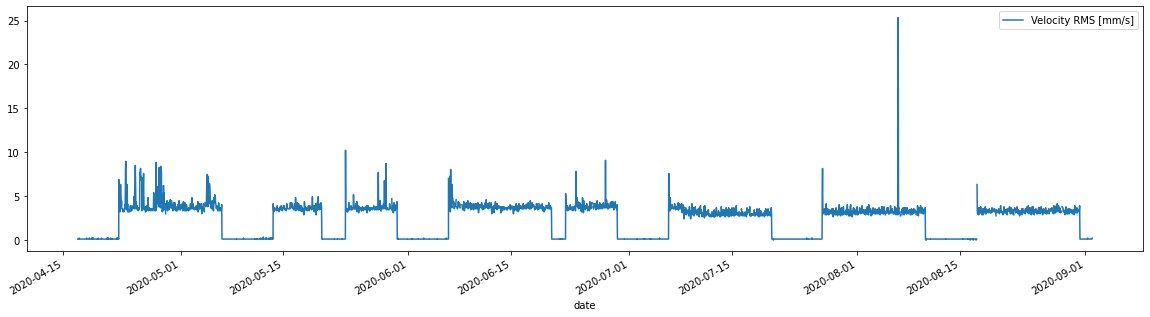

In [8]:
vibration.plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

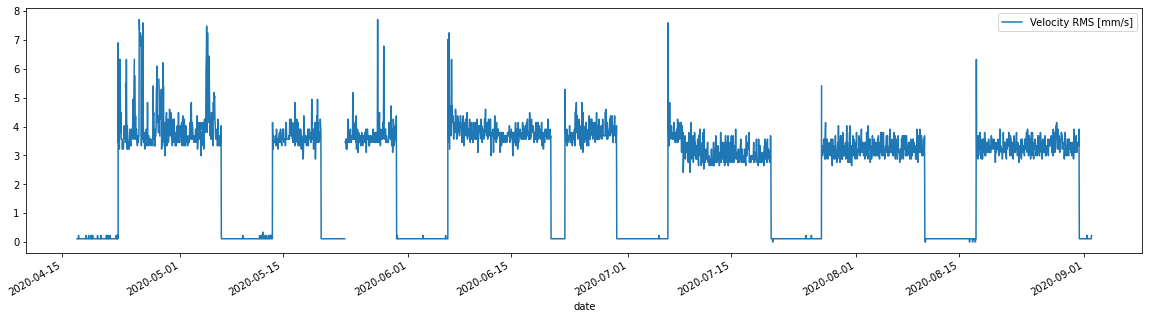

In [9]:
# Pozbywamy się błędnych danych
vibration = vibration.dropna()  # NaN

# Outliers
sigma = 3
outlier_level = vibration.mean() + (vibration.std() * sigma)
vibration = vibration[vibration < outlier_level]

vibration.plot(figsize=(20,5))


# Wykorzystajmy naszą wiedzę domenową

Wygląda na to, że analizowany silnik nie pracuje 24h na dobę.

Średnia wartość wibracji jest zaniżana przez dane z chwil, gdy maszyna nie pracuje, musimy się ich pozbyć.
Żeby to zrobić, musimy wymyślić sposób na określenie czy silnik pracuje.

W paczce z danymi mamy dostępne pomiary temperatury, mocy, i częstotliwości zasilania.

Wiemy, że gdy silnik nie pracuje, to nie przepływa przez niego prąd. Skoro nie przepływa przez niego prąd to częstotliwość zasilania powinna wynosić 0.0 Hz.

Spróbujmy to wykorzystać.


In [42]:
frequency = pd.read_csv("../data/Motor1_Frequency.csv", index_col=0, header=2, parse_dates=True)
frequency = frequency.dropna()
frequency.columns = ["Frequency [Hz]"]

## Sprawdźmy dane częstotliwości zasilania


In [43]:
frequency.sample(10)

,Frequency [Hz]
date,
2020-07-18 23:06:46,35.1888
2020-04-20 14:19:52,0.0000
2020-06-06 09:34:44,0.0000
2020-08-15 10:41:09,0.0000
2020-05-08 03:27:49,0.0000
2020-06-23 15:08:44,35.0923
2020-08-15 15:41:10,0.0000
2020-06-24 17:08:47,35.1890
2020-08-29 17:54:28,35.2083


In [44]:
frequency.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3239 entries, 2020-04-17 00:19:47 to 2020-09-01 23:55:05
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frequency [Hz]  3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


In [45]:
frequency.describe()

,Frequency [Hz]
count,3239.000000
mean,22.698604
std,16.777223
min,0.000000
25%,0.000000
50%,34.913000
75%,35.188400
max,36.720200


Wygląda na to, częstotliwość będzie bardzo dobrym wskaźnikiem.
Na poniższym wykresie wyraźnie widać, że częstotliwość przyjmuje jeden z dwóch stanów.

Wartość graniczną możemy ustalić na poziomie 1 Hz.

In [46]:
FREQUENCY_LIMIT = 1.0  # Hz

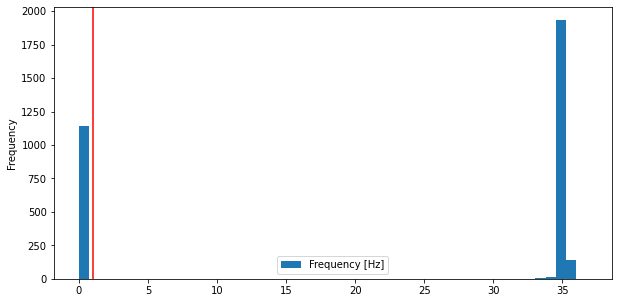

In [47]:
_, ax = plt.subplots(figsize=(10,5))
frequency.plot(kind="hist", bins=50, ax=ax)
ax.axvline(x=FREQUENCY_LIMIT, color="red")


# Porównajmy wibracje z częstotliwością zasilania

Dla pewności porównajmy przebieg wibracji z przebiegiem częstotliwości zasilania.

<AxesSubplot:xlabel='date'>

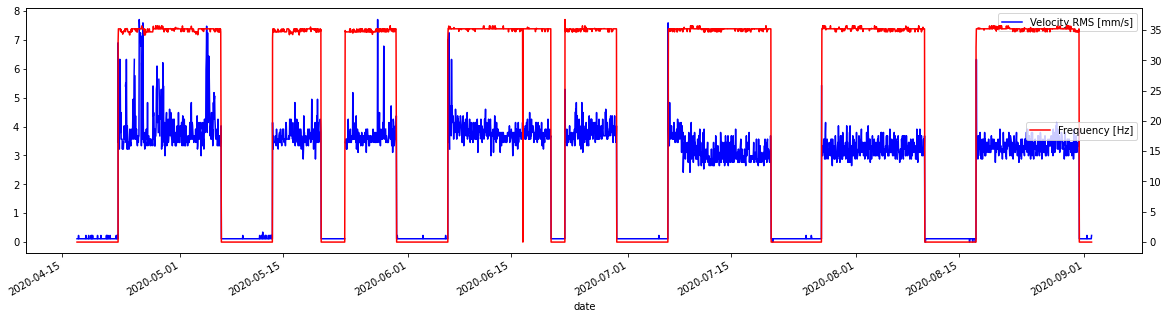

In [48]:
_, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
vibration.plot(ax=ax, color="blue")
frequency.plot(ax=ax2, color="red")

Możemy teraz wyznaczyć prostą funkcję, która określi nam chwile, w których silnik pracował.

In [49]:
motor_is_running = frequency > FREQUENCY_LIMIT
motor_is_running.sample(10)

,Frequency [Hz]
date,
2020-06-21 17:43:40,False
2020-07-27 02:07:10,False
2020-07-23 17:07:01,False
2020-08-03 18:40:19,True
2020-08-20 05:53:53,True
2020-05-06 17:27:49,False
2020-05-17 20:33:33,True
2020-07-30 14:39:53,True
2020-06-11 15:45:04,True


# Czyżbyśmy znaleźli rozwiązanie ?

In [50]:
vibration[motor_is_running].mean()

Velocity RMS [mm/s]   NaN
dtype: float64

## Jeszcze nie :(
----

# Przyjrzyjmy się uważniej obydwu zestawom danych

Połączymy je w jedną strukturę i zobaczmy, co jest nie tak.

In [51]:
df = pd.concat([vibration, frequency]).sort_index()


<AxesSubplot:xlabel='date'>

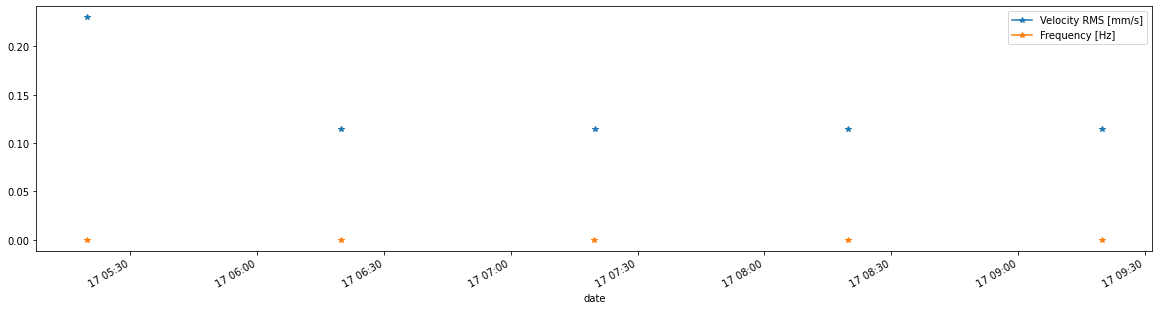

In [52]:
df[10:20].plot(figsize=(20,5), marker="*")

In [53]:
df[10:20]

,Velocity RMS [mm/s],Frequency [Hz]
date,,
2020-04-17 05:19:48,NaN,0.0
2020-04-17 05:19:51,0.2298,NaN
2020-04-17 06:19:48,NaN,0.0
2020-04-17 06:19:54,0.1149,NaN
2020-04-17 07:19:48,NaN,0.0
2020-04-17 07:19:54,0.1149,NaN
2020-04-17 08:19:48,NaN,0.0
2020-04-17 08:19:51,0.1149,NaN
2020-04-17 09:19:47,NaN,0.0


## Wniosek z obserwacji

Pomiary wibracji i częstotliwości są rozsynchronizowane.
Punkty pomiarowe pojawiają się co godzinę, ale różnią się pomiędzy sobą o kilka sekund.
Istnieje kilka sposobów, żeby te dane zsynchronizować.

1. Resampling. Jeżeli wiemy, że dane trafiają do nas raz na godzinę, możemy je zresamplować do pełnych godzin. Musimy tylko zdecydować jakiej metody agregacji użyjemy. Gdy wiemy, że w każdej grupie będzie, co najwyżej jeden pomiar, to każdy z opcji da ten sam wynik. Natomiast, gdy tych pomiarów może być więcej to decyzja ta wpływa na wynik.
    ```df.resample("1h").last()```
2. Interpolacja. Możemy uzupełnić przerwy, interpolując brakujące dane. Najłatwiej jest po prostu przepisać poprzednią wartość (interpolacja zerowego rzędu), ale czasem możemy uzyskać lepsze rezultaty stosując wyższy rząd interpolacji.
    ```df.ffill()```
3. Metoda merge_asof. Na poziomie łączenia dwóch zestawów danych możemy dokonać automatycznego dopasowania drugie wektora do pierwszego. Należy podać kolumnę, po której nastąpi dopasowanie (może to być index) i opcjonalnie tolerancję dla tego dopasowania.
    ```pd.merge_asof([s1, s2], left_index=True, right_index=True)```

In [54]:
df.resample("1h").last().sample(10)

,Velocity RMS [mm/s],Frequency [Hz]
date,,
2020-05-02 21:00:00,3.4488,NaN
2020-08-03 19:00:00,3.4488,35.1917
2020-04-24 09:00:00,3.9087,35.1479
2020-05-28 12:00:00,3.6789,35.1498
2020-06-10 12:00:00,3.1038,35.1896
2020-05-11 09:00:00,0.1149,0.0000
2020-06-06 14:00:00,7.2426,35.3608
2020-06-22 17:00:00,3.6789,35.1267
2020-05-11 03:00:00,0.1149,0.0000


In [55]:
df.ffill().sample(10)

,Velocity RMS [mm/s],Frequency [Hz]
date,,
2020-08-15 01:41:07,0.1149,0.0000
2020-04-29 20:27:41,3.6789,35.1895
2020-08-08 01:40:35,3.1038,35.1426
2020-06-07 20:45:09,4.2537,35.1899
2020-08-18 17:53:50,3.4488,35.1884
2020-07-02 00:09:04,0.1149,0.0000
2020-06-16 02:41:10,3.6789,35.1859
2020-05-09 23:27:52,0.1149,0.0000
2020-04-19 23:19:52,0.1149,0.0000


In [56]:
pd.merge_asof(left=vibration, right=frequency, left_index=True, right_index=True).sample(10)

,Velocity RMS [mm/s],Frequency [Hz]
date,,
2020-07-17 21:06:47,2.8740,35.1877
2020-06-02 23:08:50,0.1149,0.0000
2020-04-30 10:27:43,3.6789,35.4290
2020-08-05 04:40:30,3.2190,34.6782
2020-06-17 22:43:39,4.0236,35.1890
2020-06-11 05:45:15,3.9087,35.1899
2020-05-04 01:27:53,3.4488,35.1863
2020-08-31 16:55:14,0.1149,0.0000
2020-05-05 08:27:53,3.6789,35.1872


# Kolejna próba

Wybierzmy jedną z metod i spróbujmy jeszcze raz.

In [57]:
df = df.ffill()

In [58]:
is_running = df["Frequency [Hz]"] > FREQUENCY_LIMIT

In [59]:
vibration_running = df["Velocity RMS [mm/s]"][is_running]

# Przypatrzmy się wynikom


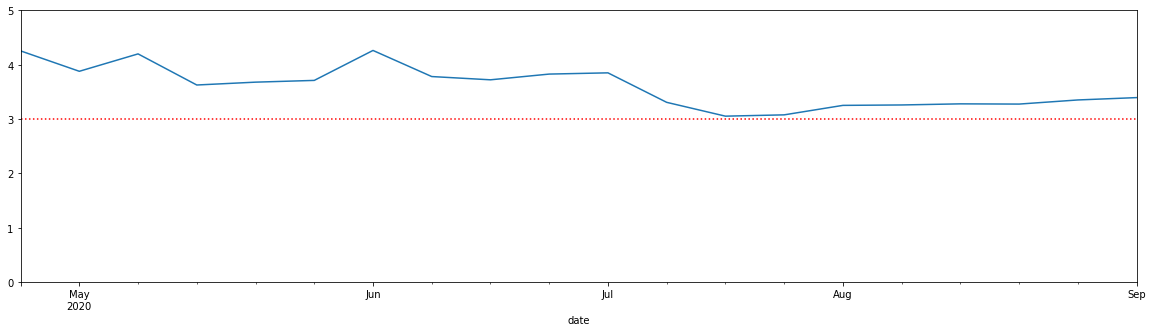

In [60]:
_, ax = plt.subplots(figsize=(20,5))
vibration_running.resample("1w").mean().plot(ax=ax, ylim=(0,5))
ax.axhline(3.0, color="red", linestyle=":")

<AxesSubplot:ylabel='date'>

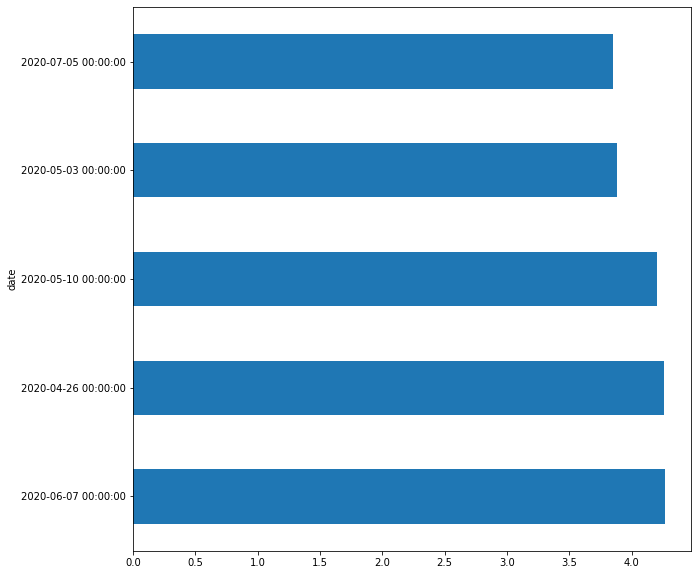

In [63]:
vibration_running.resample("1w").mean().sort_values(ascending=False).head(5).plot(kind="barh", figsize=(10,10))

# Podsumowanie

## Średni poziom drgań

Dane dotyczące analizowanego silnika pochodziły z USA i były wyskalowane w jednostkach w systemie imperialnym (in/s), natomiast
próg alarmowy podany był w jednostkach metrycznych. (3 mm/s).

Dodatkowo silnik przez znaczną część czasu nie pracował, co znacząco wpływało na całościową wartość średnią drgań.
Dzięki dodatkowym pomiarom, które były dostępne (częstotliwość zasilania), możliwe było wyznaczenie chwil, w których silnik pracował.
Na tej podstawie, można było przefiltrować dostępne pomiary wibracji.

Po usunięciu punktów pomiarowych z chwil, gdy silnik nie pracował, znacząco wzrosła średnia wartość drgań.
W każdym z analizowanych tygodni wynosiła ona powyżej 3 mm/s.

Można wiec jednoznacznie stwierdzić, że **wartości drgań w całym analizowanym przedziale przewyższały zadany poziom norm**.

## Okres o najwyższych wibracjach

W zestawie danych pomiarowych znajdował się jeden punkt pomiarowy, znacząco przewyższający wszystkie pozostałe.

Jeżeli odrzuciło się go jako wartość skrajna, to za okres o najgorszych drganiach można uznać **pierwszy tydzień Czerwca 2020**.